# Выпускной проект: Телеком — Поиск клиента с неоптимальными тарифами

<b>Задача</b>:
Найти клиентов, которые:

    а) переплачивают на текущих тарифах;
    б) сэкономят, если перейдут на более дорогой тариф.

Используйте правила формирования тарифов:

Ежемесячная плата за тариф:

    Тариф А — 4000 ₽,
    Тариф B — 2000 ₽,
    Тариф С — 1000 ₽.

Дополнительная ежемесячная плата за
каждого оператора:

    Тариф А — 50 ₽,
    Тариф B — 150 ₽,
    Тариф С — 300 ₽.
    
Входящие и внутренние звонки — бесплатны на всех тарифах,
Исходящие звонки внутри сети, включённые в тариф:

    Тариф А — 2000минут,
    Тариф B — 500 минут,
    Тариф С — нет.
    
Цена сверх лимита:

    A — 0.1 ₽/мин.,
    B — 0.15 ₽/мин.,
    C — 0.3 ₽/мин.
Исходящие звонки,
кроме внутренних:

    A — 0.3 ₽/мин.,
    B — 0.5 ₽/мин.,
    C — 0.7 ₽/мин.

<b>Описание данных</b>: Датасеты описывают использование услуг «Нупозвони» — провайдера
виртуальной телефонии. Его клиенты — колл-центры, которые:
распределяют входящие вызовы на операторов,
совершают исходящие вызовы силами операторов.
Также операторы могут делать внутренние вызовы — вызовы друг между другом
внутри сети виртуальной телефонии.:

<b>Датасет telecom_dataset.csv</b>:

Колонки:

    user_id — идентификатор клиента;
    date — дата статистики;
    direction — направление вызовов: out — исходящий вызов, in — входящий;
    internal — маркер внутренних и внешних вызовов;
    operator_id — идентификатор оператора;
    is_missed_call — маркер пропущенных вызовов;
    calls_count — количество звонков;
    call_duration — длительность звонка без учёта времени ожидания;
    total_call_duration — длительность звонка с учётом времени ожидания.

<b>Датасет telecom_clients.csv</b>:

Колонки:

    user_id — идентификатор клиента;
    tariff_plan — тарифный план клиента;
    date_start — дата регистрации клиента в сервисе.
    

<b>План проекта:</b>

    1) Обзор данных
    2) Предобработка данных
    3) Исследовательский анализ данных
    4) Поиск клиентов с неоптимальными тарифами
    5) Проверка статистических гипотез

## Обзор данных

In [346]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats as st
from plotly.subplots import make_subplots

In [347]:
telecom_db = pd.read_csv('/datasets/telecom_dataset.csv')
telecom_clients = pd.read_csv('/datasets/telecom_clients.csv')

In [348]:
telecom_db.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [349]:
telecom_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [350]:
telecom_db.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [351]:
telecom_clients.head(5)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [352]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [353]:
telecom_clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


<b>Вывод по разделу:</b> Загрузили и рассмотрели данные. В исходном датасете 53902 строки в таблице, при этом 45730 операторов.

Необходимо изменить:
    
    - столбец date привести к типу datetime, а после оставить только дату
    - столбец internal привести к типу bool
    - столбец operator_id привести к типу integer


## Предобработка данных

### Дубликаты и пропуски

In [354]:
telecom_db.duplicated().sum()

4900

In [355]:
telecom_db = telecom_db.drop_duplicates()

In [356]:
telecom_db['direction'].unique()

array(['in', 'out'], dtype=object)

In [357]:
telecom_db.isna().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [358]:
telecom_db['internal'].fillna(False, inplace=True)
telecom_db['internal'].isna().sum() # проверяем, что пропусков больше нет

0

In [359]:
telecom_clients.duplicated().sum()

0

In [360]:
telecom_clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

### Приведение столбцов к корректным типам данных

In [361]:
telecom_db['date'] = pd.to_datetime(telecom_db['date']).dt.date
telecom_db = telecom_db.astype({'internal':'bool', 'operator_id': 'Int64'})

In [362]:
telecom_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              49002 non-null  int64 
 1   date                 49002 non-null  object
 2   direction            49002 non-null  object
 3   internal             49002 non-null  bool  
 4   operator_id          41546 non-null  Int64 
 5   is_missed_call       49002 non-null  bool  
 6   calls_count          49002 non-null  int64 
 7   call_duration        49002 non-null  int64 
 8   total_call_duration  49002 non-null  int64 
dtypes: Int64(1), bool(2), int64(4), object(2)
memory usage: 3.1+ MB


In [363]:
telecom_db

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,<NA>,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10,out,True,957922,False,1,0,25
53897,168606,2019-11-10,out,True,957922,True,1,0,38
53898,168606,2019-11-11,out,True,957922,False,2,479,501
53899,168606,2019-11-15,out,True,957922,False,4,3130,3190


<b> Вывод по разделу:</b>
    
    - Пропуски есть в столбцах: internal, operator_id.
      Так как пропусков в столбце internal относительно мало, их можно заменить значением False - маркером внешнего звонка.
      Удаление строк с пропусками в operator_id не представляется возможным, а удаление приведет к потере больших
      объемов информации. Оставим пропуски в operator_id как есть.
    - Явные дубликаты удалили, неявных дубликатов не обнаружено
    - Преобразовали данные в столбцах date, internal, operator_id к корректным типам данных

## Исследовательский анализ данных

### Определим активный период

In [364]:
print(f'Дата первой записи: {telecom_db["date"].min()}')
print(f'Дата последней записи: {telecom_db["date"].max()}')

Дата первой записи: 2019-08-02
Дата последней записи: 2019-11-28


У нас есть данные с августа по ноябрь. Данные за ноябрь неполные, однако они позволят найти активных пользователей

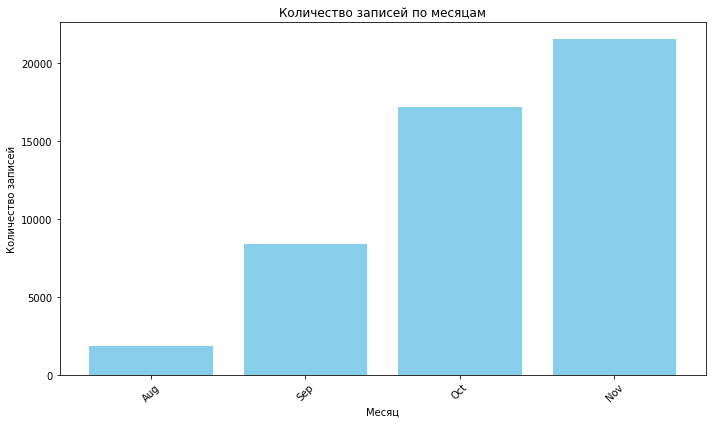

In [365]:
# Группировка данных по месяцам
telecom_db['month'] = pd.to_datetime(telecom_db['date']).dt.month

monthly_records = telecom_db.groupby('month').size().reset_index(name='records')

monthly_records['month'] = pd.to_datetime(monthly_records['month'], format='%m').dt.strftime('%b')

# Создание обычного столбчатого графика с использованием matplotlib
plt.figure(figsize=(10, 6))
plt.bar(monthly_records['month'], monthly_records['records'], color='skyblue')
plt.title('Количество записей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Как видим, в августе всего 1860 записей, что составляет менее 4% от общего числа, отбросим их

In [366]:
telecom_db = telecom_db[telecom_db['month'] != 8]

Активным периодом будем считать с сентября по ноябрь

### Подсчет количества пользователей для каждого тарифа

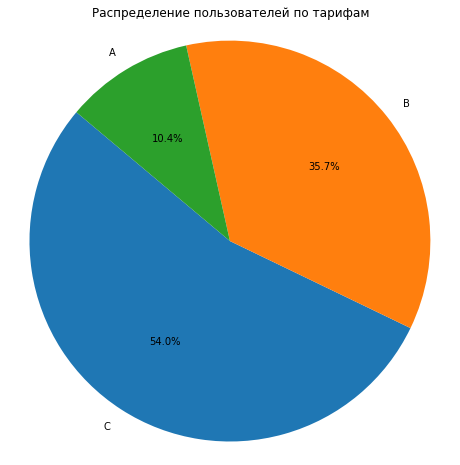

In [367]:
# Подсчет количества пользователей для каждого тарифа
tariff_counts = telecom_clients['tariff_plan'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(tariff_counts, labels=tariff_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение пользователей по тарифам')
plt.axis('equal')
plt.show()

Большинство пользователей используют тариф C(54%), на втором месте тариф В(35.7%), наименее популярный тариф А(10.4%)

### Распределение длительности звонков у клиентов

In [368]:
telecom_db_duration = telecom_db.query('direction == "out"')
duration = telecom_db_duration.groupby(['user_id', 'date'])['total_call_duration'].sum().to_frame()
fig = go.Figure()
fig.add_trace(go.Box(y=duration['total_call_duration'], name='value'))
fig.update_yaxes(range=[0, 8000])
fig.update_layout(
    title="Распределение длительности звонков в минутах, клиент/день",
    xaxis_title="Звонки",
    yaxis_title="Количество",
    title_x = 0.5
)
fig.show()

In [369]:
telecom_db['total_call_duration'].describe()

count     47142.000000
mean       1135.654830
std        4333.673755
min           0.000000
25%          47.000000
50%         211.000000
75%         902.000000
max      166155.000000
Name: total_call_duration, dtype: float64

Чаще всего общая длительность исходящих звонков в день находится в диапазоне от 306 до 3778 минут. На 1% клиентов приходится длительность исходящих вызовов более 166193 минут в день

### Среднее количество звонков по месяцам

In [370]:
# Группировка данных по user_id для расчета общего количества звонков каждого клиента
telecom_db_cnt = telecom_db.query('direction == "out"')

# Группировка данных по месяцам для расчета среднего количества звонков
monthly_avg_calls = telecom_db_cnt.groupby('month')['calls_count'].mean().reset_index()

# Преобразование периода в строку для корректного отображения на графике
monthly_avg_calls['month'] = monthly_avg_calls['month'].astype(str)

# Построение интерактивного графика со средним количеством звонков по месяцам
fig = px.line(monthly_avg_calls, x='month', y='calls_count', title='Среднее количество исходящих звонков в день по месяцам')
fig.update_layout(
    xaxis_title='Месяц',
    yaxis_title='Среднее количество звонков',
    title_x=0.5
)
fig.show()

In [371]:
telecom_db['calls_count'].describe()

count    47142.000000
mean        16.319163
std         63.639262
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       4817.000000
Name: calls_count, dtype: float64

Среднее количество исходящих звонков в день по месяцам равно 16, также по графику можно увидеть, что количество снижается, особенно спад виден в ноябре

### Определим активных клиентов

Для определения активных клиентов на основе количества звонков за ноябрь, где активными будут считаться те, кто совершил более 16 звонков

In [372]:
# Фильтрация данных только за ноябрь
november_data = telecom_db[(telecom_db['month'] == 11)]

# Группировка данных по user_id для расчета количества звонков в ноябре
calls_per_user_november = november_data.groupby('user_id')['calls_count'].sum()

# Определение активных клиентов (те, кто совершил более 10 звонков в ноябре)
active_clients = calls_per_user_november[calls_per_user_november > 16].index.tolist()

print(f'Количество активных пользователей: {len(active_clients)}')

Количество активных пользователей: 197


In [373]:
telecom_db_active = telecom_db.query('user_id in @active_clients').copy()
telecom_clients_active = telecom_clients.query('user_id in @active_clients').copy()

### Подсчёт стоимости одного месяца при использовании различных тарифов

Для начала создадим сгруппированный по клиентам и месяцам датафрейм

In [374]:
telecom_tariff = telecom_db_active.groupby(['user_id', 'month'])['calls_count'].sum().reset_index().drop('calls_count', axis=1)
telecom_tariff.head()

,user_id,month
0,166377,9
1,166377,10
2,166377,11
3,166392,9
4,166392,10


Далее рассчитаем длительность исходящих внутренних, исходящих внешних звонков для каждого оператора по месяцам, посчитаем количество операторов, также добавим инфрмацию о тарином палне клиента, и объединим это с нашим датафреймом telecom_tariff

In [375]:
# Рассчитаем длительность исходящих внутренних и внешних звонков, а также количество операторов
aggregated_data = (
    telecom_db_active.groupby(['user_id', 'month'])
    .agg(
        internal_duration=('total_call_duration', lambda x: x[(telecom_db['direction'] == 'out') & (telecom_db['internal'])].sum()),
        external_duration=('total_call_duration', lambda x: x[(telecom_db['direction'] == 'out') & (~telecom_db['internal'])].sum()),
        amount_of_operators=('operator_id', 'nunique')
    )
    .reset_index()
)

# Объединим результаты с основным датафреймом и добавим информацию о тарифных планах
telecom_tariff = (
    telecom_tariff
    .merge(aggregated_data, on=['user_id', 'month'], how='left')
    .merge(telecom_clients_active, on='user_id')
    .drop('date_start', axis=1)
)


In [376]:
# Проверим, все ли записи сохранены после объединения
original_count = aggregated_data.shape[0]
merged_count = telecom_tariff.shape[0]

print(f"Записей до объединения: {original_count}")
print(f"Записей после объединения: {merged_count}")
    
# Проверим, все ли клиенты перешли в новый набор
unique_clients_before = aggregated_data['user_id'].nunique()
unique_clients_after = telecom_tariff['user_id'].nunique()

print(f"Уникальных клиентов до объединения: {unique_clients_before}")
print(f"Уникальных клиентов после объединения: {unique_clients_after}")

# Проверим, для всех ли клиентов нашелся тариф
missing_tariff_count = telecom_tariff['tariff_plan'].isna().sum()
print(f'Виды тарифов в объединенном датафрейме: {telecom_tariff["tariff_plan"].unique()}')
print(f"Клиентов без тарифа: {missing_tariff_count}")

Записей до объединения: 492
Записей после объединения: 492
Уникальных клиентов до объединения: 197
Уникальных клиентов после объединения: 197
Виды тарифов в объединенном датафрейме: ['B' 'C' 'A']
Клиентов без тарифа: 0


In [377]:
telecom_tariff.head()

,user_id,month,internal_duration,external_duration,amount_of_operators,tariff_plan
0,166377,9,9,105835,4,B
1,166377,10,5,99207,5,B
2,166377,11,127,95384,4,B
3,166392,9,0,0,2,C
4,166392,10,0,0,2,C


In [378]:
# Создаем таблицу с тарифами
tariff_data = pd.DataFrame({
    'tariff_plan': ['A', 'B', 'C'],
    'base_fee': [4000, 2000, 1000],
    'operator_cost': [50, 150, 300],
    'included_minutes': [2000, 500, 0],
    'overage_rate': [0.1, 0.15, 0.3],
    'external_rate': [0.3, 0.5, 0.7]
})

In [379]:
# Функция для расчета стоимости
def calculate_plan(data_row):
    plan = data_row['tariff_plan']
    tariff = tariff_data[tariff_data['tariff_plan'] == plan].iloc[0]
    
    available_minutes = tariff['included_minutes'] - data_row['internal_duration']
    
    if available_minutes < 0:
        internal_cost = abs(available_minutes) * tariff['overage_rate']
    else:
        internal_cost = 0

    external_cost = data_row['external_duration'] * tariff['external_rate']
    total_cost = internal_cost + external_cost + tariff['base_fee'] + data_row['amount_of_operators'] * tariff['operator_cost']
    
    return total_cost



In [380]:
telecom_tariff.fillna(0, inplace=True)
telecom_tariff['current_price'] = round(telecom_tariff.apply(calculate_plan, axis=1), 2)
telecom_tariff.head()

,user_id,month,internal_duration,external_duration,amount_of_operators,tariff_plan,current_price
0,166377,9,9,105835,4,B,55517.5
1,166377,10,5,99207,5,B,52353.5
2,166377,11,127,95384,4,B,50292.0
3,166392,9,0,0,2,C,1600.0
4,166392,10,0,0,2,C,1600.0


In [381]:
def calculate_plan_A(data_row):
    plan = 'A'
    tariff = tariff_data[tariff_data['tariff_plan'] == plan].iloc[0]
    
    available_minutes = tariff['included_minutes'] - data_row['internal_duration']
    
    if available_minutes < 0:
        internal_cost = abs(available_minutes) * tariff['overage_rate']
    else:
        internal_cost = 0

    external_cost = data_row['external_duration'] * tariff['external_rate']
    total_cost = internal_cost + external_cost + tariff['base_fee'] + data_row['amount_of_operators'] * tariff['operator_cost']
    
    return total_cost

def calculate_plan_B(data_row):
    plan = 'B'
    tariff = tariff_data[tariff_data['tariff_plan'] == plan].iloc[0]
    
    available_minutes = tariff['included_minutes'] - data_row['internal_duration']
    
    if available_minutes < 0:
        internal_cost = abs(available_minutes) * tariff['overage_rate']
    else:
        internal_cost = 0

    external_cost = data_row['external_duration'] * tariff['external_rate']
    total_cost = internal_cost + external_cost + tariff['base_fee'] + data_row['amount_of_operators'] * tariff['operator_cost']
    
    return total_cost

def calculate_plan_C(data_row):
    plan = 'C'
    tariff = tariff_data[tariff_data['tariff_plan'] == plan].iloc[0]
    
    available_minutes = tariff['included_minutes'] - data_row['internal_duration']
    
    if available_minutes < 0:
        internal_cost = abs(available_minutes) * tariff['overage_rate']
    else:
        internal_cost = 0

    external_cost = data_row['external_duration'] * tariff['external_rate']
    total_cost = internal_cost + external_cost + tariff['base_fee'] + data_row['amount_of_operators'] * tariff['operator_cost']
    
    return total_cost

In [382]:
telecom_tariff['price_A'] = telecom_tariff.apply(lambda row: round(calculate_plan_A(row), 2), axis=1)
telecom_tariff['price_B'] = telecom_tariff.apply(lambda row: round(calculate_plan_B(row), 2), axis=1)
telecom_tariff['price_C'] = telecom_tariff.apply(lambda row: round(calculate_plan_C(row), 2), axis=1)

In [383]:
telecom_tariff.head(5)

,user_id,month,internal_duration,external_duration,amount_of_operators,tariff_plan,current_price,price_A,price_B,price_C
0,166377,9,9,105835,4,B,55517.5,35950.5,55517.5,76287.2
1,166377,10,5,99207,5,B,52353.5,34012.1,52353.5,71946.4
2,166377,11,127,95384,4,B,50292.0,32815.2,50292.0,69006.9
3,166392,9,0,0,2,C,1600.0,4100.0,2300.0,1600.0
4,166392,10,0,0,2,C,1600.0,4100.0,2300.0,1600.0


In [384]:
telecom_tariff_data = telecom_tariff.copy()
telecom_tariff.drop(['internal_duration', 'external_duration', 'amount_of_operators'], axis=1, inplace=True)
telecom_tariff.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C
0,166377,9,B,55517.5,35950.5,55517.5,76287.2
1,166377,10,B,52353.5,34012.1,52353.5,71946.4
2,166377,11,B,50292.0,32815.2,50292.0,69006.9
3,166392,9,C,1600.0,4100.0,2300.0,1600.0
4,166392,10,C,1600.0,4100.0,2300.0,1600.0


<b>Вывод по разделу:</b>

- Активным периодом будем считать с сентября по ноябрь, данные за август отбросим, т.к они составляют менее 4% от общего числа
- Большинство пользователей используют тариф C(54%), на втором месте тариф В(35.7%), наименее популярный тариф А(10.4%)
- Чаще всего общая длительность исходящих звонков в день находится в диапазоне от 306 до 3778 минут. На 1% клиентов приходится длительность исходящих вызовов более 166193 минут в день
- Среднее количество исходящих звонков по месяцам равно 16, также по графику можно увидеть, что количество снижается, особенно спад виден в ноябре
- Активными будут считаться те клиенты, которые совершили более 16 звонков за последний меясц (ноябрь). Количество активных пользователей: 197
- Подсчитали стоимости одного месяца при использовании различных тарифов.

## Поиск клиентов с неоптимальными тарифами

### Переплата клиентов и лучший тариф

In [385]:
# стоимость по самому выгодному тарифу
telecom_tariff['best_price'] = telecom_tariff.apply(lambda x: min(x['price_A'], x['price_B'], x['price_C']), axis=1)
telecom_tariff.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_price
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,35950.5
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,34012.1
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,32815.2
3,166392,9,C,1600.0,4100.0,2300.0,1600.0,1600.0
4,166392,10,C,1600.0,4100.0,2300.0,1600.0,1600.0


In [386]:
# столбец с переплатой в сравнении с лучшим тарифом
telecom_tariff['overpayment'] = telecom_tariff['current_price'] - telecom_tariff['best_price']

telecom_tariff.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_price,overpayment
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,35950.5,19567.0
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,34012.1,18341.4
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,32815.2,17476.8
3,166392,9,C,1600.0,4100.0,2300.0,1600.0,1600.0,0.0
4,166392,10,C,1600.0,4100.0,2300.0,1600.0,1600.0,0.0


In [387]:
print(f'{round(telecom_tariff[telecom_tariff["overpayment"] != 0].shape[0] / telecom_tariff.shape[0] * 100, 2)}% клиентов пользуются',
     'не самым выгодным тарифом и переплачивают.')

62.8% клиентов пользуются не самым выгодным тарифом и переплачивают.


### Клиенты с неоптимальным тарифом

In [388]:
suboptimal_tariff = telecom_tariff.query('overpayment > 0')
suboptimal_tariff.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_price,overpayment
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,35950.5,19567.0
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,34012.1,18341.4
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,32815.2,17476.8
6,166405,9,B,62971.5,40422.9,62971.5,86720.1,40422.9,22548.6
7,166405,10,B,192459.7,117850.8,192459.7,268718.6,117850.8,74608.9


In [389]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=suboptimal_tariff['overpayment'],
    name='Переплата',
    boxpoints='outliers'  # Показываем только выбросы
))

fig.update_layout(
    title="Распределение переплаты пользователей",
    xaxis_title="",
    yaxis_title="Сумма",
    yaxis=dict(
        type='log',  # Логарифмическая шкала для лучшего отображения
        autorange=True
    ),
    title_x=0.5
)

fig.show()

Медианная переплата составляет 2250 рублей. Максимальное значени достигает 286 тысяч рублей

In [390]:
# таблица вида "клиент - старый тариф - новый тариф"
client_tariff_comparison = suboptimal_tariff[['user_id', 'current_price', 'best_price']]

# Переименовываем столбцы для ясности
client_tariff_comparison.columns = ['клиент', 'старый_тариф', 'новый_тариф']

# Отображаем первые строки таблицы
print(client_tariff_comparison.head())

   клиент  старый_тариф  новый_тариф
0  166377       55517.5      35950.5
1  166377       52353.5      34012.1
2  166377       50292.0      32815.2
6  166405       62971.5      40422.9
7  166405      192459.7     117850.8


In [391]:
# Подсчет суммарной переплаты и текущей стоимости за 3 месяца для каждого пользователя
user_summary = suboptimal_tariff.groupby('user_id').agg({
    'overpayment': 'sum',
    'current_price': 'sum'
}).reset_index()

# Определение критерия переплаты
user_summary['overpayment_ratio'] = user_summary['overpayment'] / user_summary['current_price']

# Объединение с оригинальным DataFrame
suboptimal_tariff = suboptimal_tariff.merge(user_summary[['user_id', 'overpayment_ratio']], on='user_id')

# Заполнение столбца optimal_tariff
suboptimal_tariff['optimal_tariff'] = suboptimal_tariff.apply(
    lambda row: row['best_price'] if row['overpayment_ratio'] > 0.15 else row['current_price'],
    axis=1
)

# Результат
display(suboptimal_tariff.head(10))

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_price,overpayment,overpayment_ratio,optimal_tariff
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,35950.5,19567.0,0.350178,35950.5
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,34012.1,18341.4,0.350178,34012.1
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,32815.2,17476.8,0.350178,32815.2
3,166405,9,B,62971.5,40422.9,62971.5,86720.1,40422.9,22548.6,0.383779,40422.9
4,166405,10,B,192459.7,117850.8,192459.7,268718.6,117850.8,74608.9,0.383779,117850.8
5,166405,11,B,206613.0,126447.8,206613.0,288212.7,126447.8,80165.2,0.383779,126447.8
6,166406,9,B,58044.5,37546.7,58044.5,79650.7,37546.7,20497.8,0.342739,37546.7
7,166406,10,B,58020.6,37504.1,58020.6,79787.1,37504.1,20516.5,0.342739,37504.1
8,166406,11,B,25947.0,18288.2,25947.0,34705.8,18288.2,7658.8,0.342739,18288.2
9,166407,9,A,5389.8,5389.8,4952.2,6349.4,4952.2,437.6,0.081190,5389.8


In [392]:
suboptimal_tariff['overpayment_ratio'].mean()

0.32279754433153024

In [393]:
suboptimal_tariff['overpayment_ratio'].min()

0.016129032258064516

In [394]:
# Функция для получения названия тарифа по цене
def get_tariff_by_price(row, price):
    if price == row['price_A']:
        return 'A'
    elif price == row['price_B']:
        return 'B'
    elif price == row['price_C']:
        return 'C'
    return None

new_table = suboptimal_tariff[['user_id', 'current_price', 'optimal_tariff']].drop_duplicates()

# Определение старого и нового тарифов
new_table['current_tariff'] = suboptimal_tariff.apply(lambda row: get_tariff_by_price(row, row['current_price']), axis=1)
new_table['new_tariff'] = suboptimal_tariff.apply(lambda row: get_tariff_by_price(row, row['optimal_tariff']), axis=1)

final_table = new_table[['user_id', 'current_tariff', 'new_tariff']].drop_duplicates()

In [395]:
final_table['current_tariff'].isna().sum()

0

In [396]:
final_table['new_tariff'].isna().sum()

0

In [397]:
final_table.head(10)

,user_id,current_tariff,new_tariff
0,166377,B,A
3,166405,B,A
6,166406,B,A
9,166407,A,A
10,166428,B,C
13,166485,B,A
16,166487,C,C
17,166495,B,A
20,166503,B,A
22,166511,C,A


In [398]:
# Подсчет количества пользователей для каждого текущего тарифа
current_tariff_counts = final_table['current_tariff'].value_counts()

# Подсчет количества пользователей для каждого нового тарифа
new_tariff_counts = final_table['new_tariff'].value_counts()

colors_current = ['#636EFA', '#EF553B', '#00CC96']
colors_new = ['#FF6692', '#FFA15A', '#19D3F3']

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Текущие тарифы', 'Новые тарифы'])

# Добавление круговой диаграммы для текущих тарифов
fig.add_trace(go.Pie(labels=current_tariff_counts.index, values=current_tariff_counts, 
                     name="Текущие тарифы", marker=dict(colors=colors_current),
                     textinfo='label+percent', insidetextorientation='radial',
                     legendgroup='group1', showlegend=False), 1, 1)

# Добавление круговой диаграммы для новых тарифов
fig.add_trace(go.Pie(labels=new_tariff_counts.index, values=new_tariff_counts, 
                     name="Новые тарифы", marker=dict(colors=colors_new),
                     textinfo='label+percent', insidetextorientation='radial',
                     legendgroup='group2', showlegend=False), 1, 2)
fig.update_layout(title_text='Распределение пользователей по тарифам', title_x=0.5,
                  legend=dict(x=0.5, y=0.5, traceorder='grouped', font=dict(size=10)))

fig.show()

### Подсчёт выручки при действующих и более выгодных тарифных планах

In [399]:
print(f'Выручка при действующих тарифных планах: {round(suboptimal_tariff["current_price"].sum())} рублей.')

Выручка при действующих тарифных планах: 9714198 рублей.


In [400]:
print('Выручка, если заменить все тарифные планы на самые выгодные: ',
      f'{round(suboptimal_tariff["optimal_tariff"].sum())} рублей.\n\n',
      f'Это на {round((suboptimal_tariff["current_price"].sum() / suboptimal_tariff["optimal_tariff"].sum() - 1) * 100, 1)}',
      '% меньше выручки по действующим тарифам.', sep='')

Выручка, если заменить все тарифные планы на самые выгодные: 5518653 рублей.

Это на 76.0% меньше выручки по действующим тарифам.


In [401]:
# Данные для графика
current_revenue = suboptimal_tariff["current_price"].sum()
best_revenue = suboptimal_tariff["optimal_tariff"].sum()

# Создание графика
fig = go.Figure()

# Добавление столбцов для текущего и лучшего тарифа
fig.add_trace(go.Bar(
    x=['Текущий тариф', 'Лучший тариф'],
    y=[current_revenue, best_revenue],
    marker_color=['green', 'red']
))

# Настройка внешнего вида графика
fig.update_layout(
    title="Сравнение выручки по текущему и лучшему тарифу",
    xaxis_title="Тип тарифа",
    yaxis_title="Выручка (руб.)",
    title_x=0.5
)

# Отображение графика
fig.show()


Самый эффективный способ минимизировать количество уходов клиентов - предложить им перейти на самый выгодный тариф, однако в данном случае сильно страдает значение выручки: на 76% убытков компания вряд ли готова пойти

In [402]:
suboptimal_tariff_november = suboptimal_tariff.query('month == 11')

In [403]:
print(f'Выручка при действующих тарифных планах: {round(suboptimal_tariff_november["current_price"].sum())} рублей.')

Выручка при действующих тарифных планах: 4332591 рублей.


In [404]:
print('Выручка, если заменить все тарифные планы на самые выгодные: ',
      f'{round(suboptimal_tariff_november["optimal_tariff"].sum())} рублей.\n\n',
      f'Это на {round((suboptimal_tariff_november["current_price"].sum() / suboptimal_tariff_november["optimal_tariff"].sum() - 1) * 100, 1)}',
      '% меньше выручки по действующим тарифам.', sep='')

Выручка, если заменить все тарифные планы на самые выгодные: 2468113 рублей.

Это на 75.5% меньше выручки по действующим тарифам.


### Выручка в разрезе тарифов

In [405]:
revenue_by_tariffs = telecom_tariff.groupby('tariff_plan')['current_price'].sum().sort_values(ascending=False).reset_index()
revenue_by_tariffs.head()

,tariff_plan,current_price
0,A,5994605.6
1,C,5753527.1
2,B,4159271.7


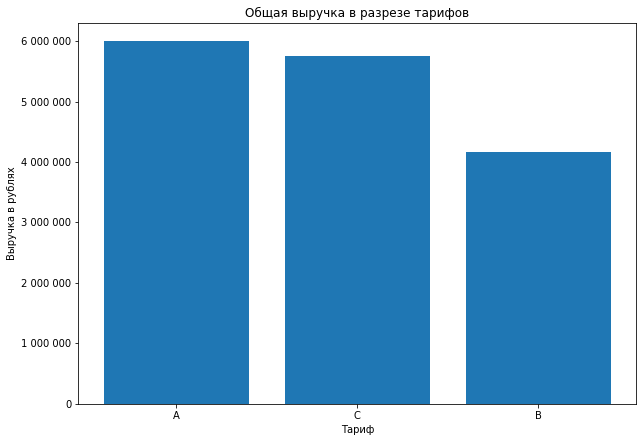

In [406]:
plt.figure(figsize=(10, 7))

# Построение графика
plt.bar(x=revenue_by_tariffs['tariff_plan'], 
        height=revenue_by_tariffs['current_price'].sort_values(ascending=False))

# Настройка заголовков и меток
plt.title('Общая выручка в разрезе тарифов')
plt.xlabel('Тариф')
plt.ylabel('Выручка в рублях')

# Форматирование меток на оси Y
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.show()

Клиенты с тарифом А приносят больше прибыли, чем клиенты с тарифами С и В. Тариф В имеет самую низкую прибыль среди всех тарифов.

### Как уменьшить риск падения выручки, если все клиенты перейдут на более выгодные тарифы?

Вместо самого выгодного тарифа можно предложить клиентам средний тариф с бонусами, который включает
дополнительные услуги и бонусы.

Бонусы и услуги:

- Бесплатные консультации.
- Дополнительные минуты/ГБ.
- Скидки на новые услуги.

In [407]:
suboptimal_tariff_optim = suboptimal_tariff.copy()

# Обновлённая таблица с тарифами. D - средний тариф
tariff_data = pd.DataFrame({
    'tariff_plan': ['D'],
    'base_fee': [1000],
    'operator_cost': [90],
    'included_minutes': [600],
    'overage_rate': [0.2],
    'external_rate': [0.4]
})

In [408]:
suboptimal_tariff_optim

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_price,overpayment,overpayment_ratio,optimal_tariff
0,166377,9,B,55517.5,35950.5,55517.5,76287.2,35950.5,19567.0,0.350178,35950.5
1,166377,10,B,52353.5,34012.1,52353.5,71946.4,34012.1,18341.4,0.350178,34012.1
2,166377,11,B,50292.0,32815.2,50292.0,69006.9,32815.2,17476.8,0.350178,32815.2
3,166405,9,B,62971.5,40422.9,62971.5,86720.1,40422.9,22548.6,0.383779,40422.9
4,166405,10,B,192459.7,117850.8,192459.7,268718.6,117850.8,74608.9,0.383779,117850.8
...,...,...,...,...,...,...,...,...,...,...,...
304,168481,11,B,2662.5,4277.5,2662.5,2197.5,2197.5,465.0,0.174648,2197.5
305,168579,11,B,2300.0,4100.0,2300.0,1600.0,1600.0,700.0,0.304348,1600.0
306,168583,10,B,2150.0,4050.0,2150.0,1300.0,1300.0,850.0,0.348315,1300.0
307,168583,11,B,2300.0,4100.0,2300.0,1600.0,1600.0,700.0,0.348315,1600.0


In [409]:
def calculate_plan_D(data_row):
    plan = 'D'  # Выбираем тарифный план D
    tariff = tariff_data[tariff_data['tariff_plan'] == plan].iloc[0]
    
    available_minutes = tariff['included_minutes'] - data_row['internal_duration']
    
    if available_minutes < 0:
        internal_cost = abs(available_minutes) * tariff['overage_rate']
    else:
        internal_cost = 0

    external_cost = data_row['external_duration'] * tariff['external_rate']
    total_cost = internal_cost + external_cost + tariff['base_fee'] + data_row['amount_of_operators'] * tariff['operator_cost']
    
    # Добавляем стоимость бонусов
    total_cost += 5000
    
    return total_cost

In [410]:
suboptimal_tariff_optim['price_D'] = round(telecom_tariff_data.apply(calculate_plan_D, axis=1), 2)

Также применим это к тем клиентам, переплата которых за 3 месяца больше 15%

In [411]:
suboptimal_tariff_optim['new_optimal_tariff'] = suboptimal_tariff_optim.apply(
    lambda row: row['price_D'] if row['overpayment_ratio'] > 0.15 else row['current_price'],
    axis=1
)

In [412]:
print('Выручка, если заменить все тарифные планы на средние: ',
      f'{round(suboptimal_tariff_optim["new_optimal_tariff"].sum())} рублей.\n\n',
      f'Это на {round((suboptimal_tariff_optim["current_price"].sum() / suboptimal_tariff_optim["new_optimal_tariff"].sum() - 1) * 100, 1)}',
      '% меньше выручки по действующим тарифам.', sep='')

Выручка, если заменить все тарифные планы на средние: 7626220 рублей.

Это на 27.4% меньше выручки по действующим тарифам.


In [413]:
# Данные для графика
current_revenue = suboptimal_tariff_optim["current_price"].sum()
new_tariff_revenue = suboptimal_tariff_optim["new_optimal_tariff"].sum()

# Создание графика
fig = go.Figure()

# Добавление данных для круговой диаграммы
fig.add_trace(go.Pie(
    labels=['Текущий тариф', 'Средний тариф'],
    values=[current_revenue, new_tariff_revenue],
    hole=0.3,
    marker=dict(colors=['#aab8c2', '#f4a261']),  # Цвета секторов
    textinfo='label+value',
    showlegend=True
))

# Настройка внешнего вида графика
fig.update_layout(
    title="Выручка по текущему и среднему тарифу",
    title_x=0.5
)

# Отображение графика
fig.show()


Как видим, данный тариф поможет сократить разницу в потере выручки с 76% до 27%, что сохранит выручку на оптимальном уровне, а также поможет удержать старых и привлечь новых клентов, благодаря выгодным условиям

<b>Вывод по разделу:</b>

- 62.8% клиентов пользуются не самым выгодным тарифом и переплачивают. Медианная переплата составляет 2250 рублей. Максимальное значение переплаты достигает 286 тысяч рублей
- Выручка упадёт на 76%, если заменить все тарифные планы на самые выгодные
- Клиенты с тарифом А приносят больше прибыли, чем клиенты с тарифами С и Б. Тариф В имеет самую низкую прибыль среди всех тарифов.
- Вместо самого выгодного тарифа можно предложить клиентам средний тариф с бонусами, который сократит падение выручки с 76 до 20 процентов

## Проверка статистических гипотез

### Выручка после оптимизации

H0: "Нет доказательств того, что выручка компании уменьшится после оптимизации."

H1: "Выручка компании снизится после оптимизации."

Для проверки гипотез используем общую выручку по каждому активному клиенту, так как они участвуют в оптимизации. Нормальность распределения проверим с помощью теста Шапиро-Уилка.

In [414]:
alpha = 0.05

results = st.shapiro(suboptimal_tariff_optim['current_price'])
p_value = results[1]

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение в исходном датасете не нормально')
else:
    print('Распределение в исходном датасете нормально')
    
results = st.shapiro(suboptimal_tariff_optim['price_D'])
p_value = results[1]

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение в оптимизированном датасете не нормально')
else:
    print('Распределение в оптимизированном датасете нормально')   

p-значение:  3.921311570722749e-28
Распределение в исходном датасете не нормально
p-значение:  2.5116675295537024e-35
Распределение в оптимизированном датасете не нормально


Так как наши выборки зависимы (т.е. каждая пара значений относится к одному и тому же клиенту), то нам следует использовать тест Уилкоксона).

In [415]:
# Применяем тест Уилкоксона
results = st.wilcoxon(suboptimal_tariff_optim['current_price'], suboptimal_tariff_optim['price_D'], alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выручка статистически значимо снизилась после оптимизации')
else:
    print('Не удалось отвергнуть нулевую гипотезу: нет статистически значимых изменений в выручке')

p-значение: 0.9058060982472074
Не удалось отвергнуть нулевую гипотезу: нет статистически значимых изменений в выручке


###  Цена услуг на тарифных планах A и B в ноябре

Нулевая гипотеза (H0):

- "Цены услуг на тарифных планах A и B в ноябре различаются."

Альтернативная гипотеза (H1):

- "Цены услуг на тарифных планах A и B в ноябре равны"

In [416]:
telecom_tariff_nov = telecom_tariff.query('month == 11')
plan_A_prices = telecom_tariff_nov[telecom_tariff_nov['tariff_plan'] == 'A']['current_price']
plan_B_prices = telecom_tariff_nov[telecom_tariff_nov['tariff_plan'] == 'B']['current_price']

results = st.shapiro(plan_A_prices)
p_value = results[1]

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение в исходном датасете не нормально')
else:
    print('Распределение в исходном датасете нормально')
    
results = st.shapiro(plan_B_prices)
p_value = results[1]

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение в оптимизированном датасете не нормально')
else:
    print('Распределение в оптимизированном датасете нормально') 

p-значение:  2.530879061879432e-09
Распределение в исходном датасете не нормально
p-значение:  3.238904573688549e-14
Распределение в оптимизированном датасете не нормально


Т.к распределение не нормально и выборки независимы, будем использовать тест Манна-Уитни для сравнения двух независимых выборок.

In [417]:
# Применяем тест Манна-Уитни
results = st.mannwhitneyu(plan_A_prices, plan_B_prices)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние цены на тарифные планы A и B различаются')
else:
    print('Не удалось отвергнуть нулевую гипотезу: нет статистически значимых различий в средних ценах между тарифными планами A и B')

p-значение: 0.00654662680988348
Отвергаем нулевую гипотезу: средние цены на тарифные планы A и B различаются


Тест подтверждает гипотезу о том, что цены услуг на тарифных планах A и B различаются.

<b>Вывод по разделу:</b> В результате проведения тестов статистической значимости можно сказать, что обе гипотезы подтвердились: 1) Нет доказательств того, что выручка компании уменьшится после оптимизации 2) Цены услуг на тарифных планах A и B различаются

## Общий вывод

- Активный период определен с сентября по ноябрь; данные за август исключены, так как они составляют менее 4% от общего объема.
- Наибольшее количество пользователей выбрали тариф C (54%), второе место занимает тариф B (35.7%), а тариф A является наименее популярным (10.4%).
- Длительность исходящих звонков в день обычно колеблется от 306 до 3778 мпнут, при этом 1% клиентов имеют длительность вызовов, превышающую 166193 минуты в день.
- Среднее количество исходящих звонков в месяц составляет 16. Графики показывают снижение этой цифры, особенно заметное в ноябре.
- Активными считаются клиенты, совершившие более 16 звонков в ноябре. Общее число таких активных пользователей: 197.
- 62.79% клиентов используют тарифы, которые не являются самыми выгодными, что приводит к переплатам. Медианная переплата составляет 2250 рублей, а максимальная — 286к рублей.
- Если перейти на самые выгодные тарифные планы, выручка упадет на 76%.
- Клиенты, использующие тариф B, генерируют больше прибыли, чем пользователи тарифов C и A. Тариф A, несмотря на свою высокую стоимость, приносит наименьшую прибыль.
- Вместо наиболее выгодного тарифа можно предложить клиентам тариф среднего уровня с бонусами, что позволит уменьшить падение выручки с 76% до 20%.

Рекомендации:

1. **Оптимизация тарифных планов:**
   - **Введение промежуточного(среднего) тарифа:** Рекомендуется ввести тариф среднего уровня с бонусами вместо самого выгодного тарифа. Это позволит сохранить старых клиентов и привлечь новых, а также уменьшит падение выручки с 76% до 20%. 

2. **Повышение прозрачности и выгодности тарифов:**
   - **Информирование клиентов:** Необходимо активно информировать клиентов о выгодных тарифах и возможных переплатах. Это поможет клиентам сделать более осознанный выбор и, возможно, перейдут на более экономичные планы.

3. **Улучшение предложения для активных клиентов:**
   - **Поощрение активных клиентов:** Учитывая, что активные пользователи, совершающие более 16 звонков в месяц, составляют 197 человек, стоит рассмотреть специальные предложения или бонусы для этой группы клиентов, чтобы повысить их лояльность и сократить отток.

4. **Анализ и контроль расходов:**
   - **Регулярный мониторинг:** Важно регулярно анализировать расходы клиентов по каждому тарифному плану и корректировать тарифы на основе текущих данных, чтобы минимизировать переплаты и поддерживать баланс между стоимостью и выручкой.

## Презентация

Ссылка: https://docs.google.com/presentation/d/1FxjD7kd6UdBnF7xLRm_rlH2el4xTx54EXZQ_0YlAcYU/edit?usp=drive_link